# Titanic with Xgboost

## Base Process

1. Environment
2. Data Input
3. Feature Engineering
4. Model Build
5. Parameters Opt
6. Else Optimization Method
7. Submit

## Focus Point

1. Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
2. Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
3. Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
4. Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
5. 单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
6. 如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
7. 登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
8. 把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
9. Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。

## Enviroment

In [108]:
#coding:utf-8
## 导入模块以及环境设置
import os,sys,time

import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')

%matplotlib inline

## Data Input

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


能够看到Age字段有少量缺失，Cabin字段大量缺失，需要关注一下。

## Data Preprocess

### 字符mapping到数值

由于很多计算都需要数值型数据，因此将个别字符型mapping到数值上。

In [5]:
train_data.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [6]:
sex_map = {'male':0, 'female':1}
train_data['Sex'] = train_data.Sex.map(sex_map)
test_data['Sex'] = test_data.Sex.map(sex_map)

In [7]:
embarked_map = {'S':0, 'C':1, 'Q':2}
train_data['Embarked'] = train_data.Embarked.map(embarked_map)
test_data['Embarked'] = test_data.Embarked.map(embarked_map)

## Feature Engineering

### Data Analysis、Dig、Full、New

简单过滤一下能够得到以下信息：
1. PassengerId基本没用，这个是用于后期test数据检验的，需要后面drop掉。
2. Survived是目标字段。
3. Pclass、Sex、Age是三个最直接的可以直接用于分析的字段。
4. Age由于是数值型，但是我们数据量较少，考虑离散化。
5. Name可以根据tital提取出跟年龄相关的数据。
6. SibSp、Parch的作用不敢肯定，表面看有关系，具体要看可视化的结果。
7. Ticket作为票号，规律不知，而且不是纯数值。
8. Fare可以作为Pclass的补充，生成新字段。
9. Cabin缺失很多。
10. Embarked可能影响了上船后人们的位置，比如后上船的人可能更靠近逃生口？只是猜测。

总之，每个字段都需要分析、可视化后，观察跟Survived的关系来决定该字段是直接使用，还是挖掘、跟别的字段组合后使用。

In [8]:
print '幸存/总人数：'+str(1.*len(train_data[train_data.Survived==1])/len(train_data))

幸存/总人数：0.383838383838


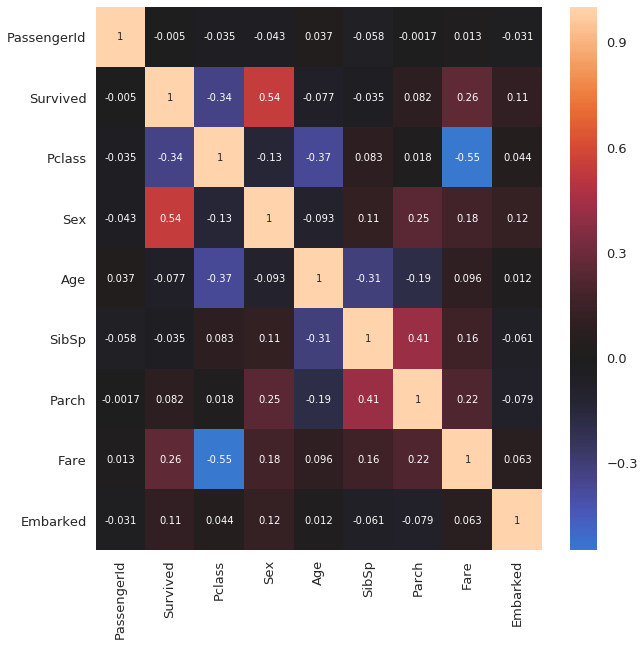

In [9]:
plt.figure(figsize=(10,10))
train_corr = train_data.corr()
sns.heatmap(train_corr, center=0, annot=True)

可以看到PassengerId跟其他字段均没有任何联系，这个就不需要分析了。

#### Name
分割FamilyName、PersonalName和Title

分割后的好处是可以结合SibSp、Parch来将一些数据作为一个Family整合，也方便后续其他字段集合Name分析。

##### new

In [10]:
train_data['Family_name'] = train_data.Name.apply(lambda n:(n.split(',')[0].strip()))
train_data['Personal_name'] = train_data.Name.apply(lambda n:(n.split(',')[1].split('.')[1].strip()))
train_data['Title'] = train_data.Name.apply(lambda n:(n.split(',')[1].split('.')[0].strip()))

test_data['Family_name'] = test_data.Name.apply(lambda n:(n.split(',')[0].strip()))
test_data['Personal_name'] = test_data.Name.apply(lambda n:(n.split(',')[1].split('.')[1].strip()))
test_data['Title'] = test_data.Name.apply(lambda n:(n.split(',')[1].split('.')[0].strip()))

In [11]:
train_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [12]:
test_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'], dtype=object)

In [13]:
title_map = {'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Don':4,'Rev':5,'Dr':6,'Mme':7,
            'Ms':8,'Major':9,'Lady':10,'Sir':11,'Mlle':12,'Col':13,'Capt':14,
            'the Countess':15,'Rev':16,'Dr':17,'Dona':18,'Jonkheer':19}

train_data['Title'] = train_data.Title.map(title_map)
test_data['Title'] = test_data.Title.map(title_map)

In [14]:
train_data[['Title']].corrwith(train_data.Survived)

Title    0.178213
dtype: float64

可以看到，Title字段跟是否幸存存在很不错的关系。

#### Age

1. 该字段有一定缺失值。
2. Age的影响在于两点：年幼年长的或许可以优先逃生、年轻力壮的生存能力更强。

先不考虑缺失值，分析剩余数据与幸存率的关系，下面以多个step为参考的幸存率关系图。

##### Full

考虑从Title中获取，用具有同一个Title的其他乘客的平均值设置。

In [15]:
train_age_title_map = dict(train_data.groupby(by='Title')['Age'].mean().fillna(20))
test_age_title_map = dict(test_data.groupby(by='Title')['Age'].mean().fillna(20))

In [16]:
def train_full_age(row):
    row['Age'] = row['Age'] if not pd.isnull(row['Age']) else train_age_title_map[row['Title']]
    return row

def test_full_age(row):
    row['Age'] = row['Age'] if not pd.isnull(row['Age']) else test_age_title_map[row['Title']]
    return row

In [17]:
train_data = train_data.apply(train_full_age, axis=1)
test_data = test_data.apply(test_full_age, axis=1)

In [18]:
print 'train data Age has null:'+str(train_data.Age.hasnans)+',test data Age has null:'+str(test_data.Age.hasnans)

train data Age has null:False,test data Age has null:False


##### Dig

In [19]:
age_data = train_data[['Age','Survived', 'Sex']].copy()

In [20]:
age_data['Age_3'] = age_data.Age.apply(lambda a:int(a/3))
age_data['Age_5'] = age_data.Age.apply(lambda a:int(a/5))
age_data['Age_8'] = age_data.Age.apply(lambda a:int(a/8))
age_data['Age_10'] = age_data.Age.apply(lambda a:int(a/10))
age_data['Age_15'] = age_data.Age.apply(lambda a:int(a/15))
age_data['Age_20'] = age_data.Age.apply(lambda a:int(a/20))
# 儿童-6、少年7-14、青年15-35、中年36-60、老年61-
age_data['Age_x'] = age_data.Age.apply(lambda a:0 if a<=6 else (1 if a<=14 else (2 if a<=35 else (3 if a<=60 else 4))))
age_data['Age_child'] = age_data.Age.apply(lambda a:0 if a<=6 else 1)

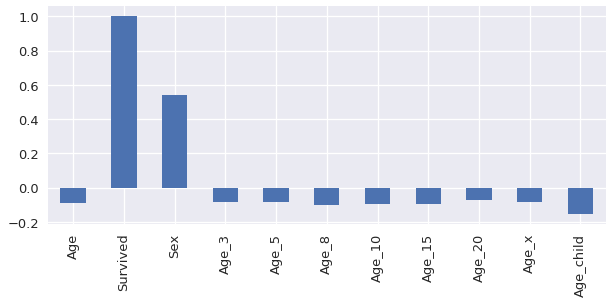

In [21]:
plt.figure(figsize=(10,4))
age_corr = age_data.corrwith(age_data.Survived)
age_corr.plot(kind='bar')

从相关性来看，最高的是Age_child，也就是是否是儿童，其次是Age_8，按照步长为8划分的年龄段，均不到-0.2。

尝试加入性别再看看。

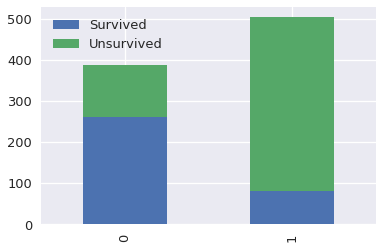

In [22]:
def is_youngman(row):
    row['Is_youngman'] = 1 if row['Age_8']>=2 and row['Age_8']<=6 and row['Sex']==0 else 0
    return row
age_data = age_data.apply(is_youngman, axis=1)
Survived_0 = age_data.Is_youngman[age_data.Survived == 0].value_counts()
Survived_1 = age_data.Is_youngman[age_data.Survived == 1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1, u'Unsurvived':Survived_0})
df.plot(kind='bar', stacked=True)

明显看到这一属性还是很有用的，大大提升了男性的幸存率，看看相关系数。

In [23]:
print 'Is_youngman corr with Survived:'+str(age_data.Is_youngman.corr(age_data.Survived))

Is_youngman corr with Survived:-0.516985258962


##### new

In [24]:
train_data['Age_8'] = train_data.Age.apply(lambda a:int(a/8))
test_data['Age_8'] = test_data.Age.apply(lambda a:int(a/8))

train_data['Is_child'] =train_data.Age.apply(lambda a:1 if a<=6 else 0)
test_data['Is_child'] = test_data.Age.apply(lambda a:1 if a<=6 else 0)

# 测试结果显示该字段带来的负面作用大于正面
#train_data = train_data.apply(is_youngman, axis=1)
#test_data = test_data.apply(is_youngman, axis=1)

#### Sex

毫无疑问，性别是一个非常重要的属性，并且它是完成的，没有nan值，nice。

PS:0 for male, 1 for female

In [25]:
sex_data = train_data[['Sex','Pclass','Survived']].copy()

##### Dig

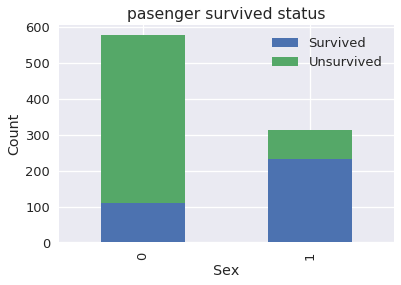

In [26]:
Survived_0 = sex_data.Sex[sex_data.Survived == 0].value_counts()
Survived_1 = sex_data.Sex[sex_data.Survived == 1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1, u'Unsurvived':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Sex") 
plt.ylabel(u"Count") 

可以看到，女性幸存率远远高于男性。

结合Pclass来看呢。

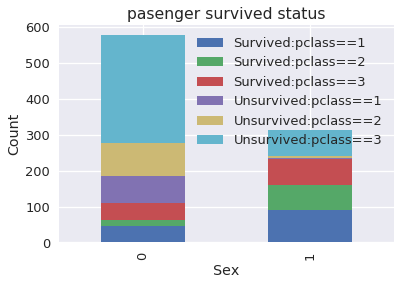

In [27]:
Survived_0_pclass1 = sex_data.Sex[sex_data.Pclass==1][sex_data.Survived==0].value_counts()
Survived_0_pclass2 = sex_data.Sex[sex_data.Pclass==2][sex_data.Survived==0].value_counts()
Survived_0_pclass3 = sex_data.Sex[sex_data.Pclass==3][sex_data.Survived==0].value_counts()
Survived_1_pclass1 = sex_data.Sex[sex_data.Pclass==1][sex_data.Survived==1].value_counts()
Survived_1_pclass2 = sex_data.Sex[sex_data.Pclass==2][sex_data.Survived==1].value_counts()
Survived_1_pclass3 = sex_data.Sex[sex_data.Pclass==3][sex_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived:pclass==1':Survived_1_pclass1,
                 u'Survived:pclass==2':Survived_1_pclass2,
                 u'Survived:pclass==3':Survived_1_pclass3,
                 u'Unsurvived:pclass==1':Survived_0_pclass1,
                 u'Unsurvived:pclass==2':Survived_0_pclass2,
                 u'Unsurvived:pclass==3':Survived_0_pclass3,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Sex") 
plt.ylabel(u"Count") 

可以看到，pclass为2,3的男性乘客的幸存率很低，而pclass为1,2的女性乘客则非常高，可以利用这两个特点。

##### new

In [28]:
def new_female_pclass12(row):
    row['Is_female_pclass12'] = 1 if(row['Sex']==1 and row['Pclass'] in [1,2]) else 0
    return row

def new_male_pclass23(row):
    row['Is_male_pclass23'] = 1 if(row['Sex']==0 and row['Pclass'] in [2,3]) else 0
    return row

In [29]:
train_data = train_data.apply(new_female_pclass12, axis=1)
test_data = test_data.apply(new_female_pclass12, axis=1)

train_data = train_data.apply(new_male_pclass23, axis=1)
test_data = test_data.apply(new_male_pclass23, axis=1)

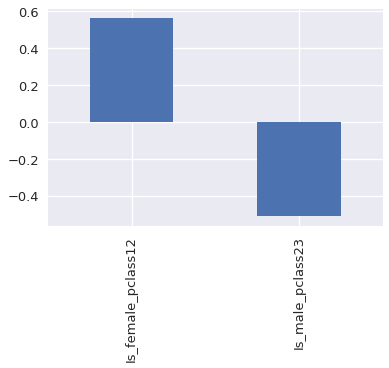

In [30]:
train_data[['Is_female_pclass12','Is_male_pclass23']].corrwith(train_data.Survived).plot(kind='bar')

#### Pclass

之前的热图可以看到Pclass跟Survived的相关性有-0.34，非常高了，说明船舱等级同样对与是否幸存影响很大。

##### Dig

In [31]:
pclass_data = train_data[['Pclass','Fare','Survived','Sex']].copy()

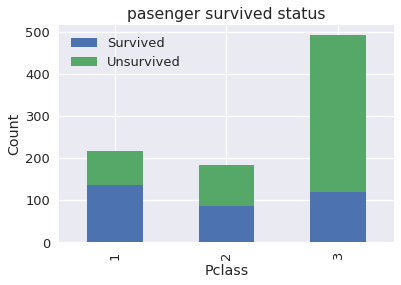

In [32]:
Survived_0 = pclass_data.Pclass[pclass_data.Survived==0].value_counts()
Survived_1 = pclass_data.Pclass[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Pclass") 
plt.ylabel(u"Count") 

非常明显的差异表现，更高级的船舱对应更高的幸存率。

我们知道虽然Pclass有3个级别，但是对应应该有更多的细分，比如是否靠窗、是否有独立卫生间等等，因此结合Fare细分处理。

将原本的Pclass:1,2,3细分为11,12,13,21,22,23,31,32,33

In [33]:
quantile_1_25 = pclass_data[pclass_data.Pclass==1].Fare.quantile(0.25)
quantile_1_50 = pclass_data[pclass_data.Pclass==1].Fare.quantile(0.5)
quantile_1_75 = pclass_data[pclass_data.Pclass==1].Fare.quantile(0.75)
quantile_1_100 = pclass_data[pclass_data.Pclass==1].Fare.quantile(1)

quantile_2_25 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.25)
quantile_2_50 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.5)
quantile_2_75 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.75)
quantile_2_100 = pclass_data[pclass_data.Pclass==2].Fare.quantile(1)

quantile_3_25 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.25)
quantile_3_50 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.5)
quantile_3_75 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.75)
quantile_3_100 = pclass_data[pclass_data.Pclass==2].Fare.quantile(1)

quantiles = [[quantile_1_25,quantile_1_50,quantile_1_75,quantile_1_100],
             [quantile_2_25,quantile_2_50,quantile_2_75,quantile_2_100],
             [quantile_3_25,quantile_3_50,quantile_3_75,quantile_3_100]]

def pclass_x(row):
    pclass = int(row['Pclass'])
    fare = row['Fare']
    #row['Pclass_x'] = 10*pclass+(1 if fare<=quantiles[pclass-1][0] else (2 if fare<=quantiles[pclass-1][1] else (3 if fare<=quantiles[pclass-1][2] else 4)))
    row['Pclass_x'] = 10*pclass+(1 if fare<=quantiles[pclass-1][1] else 2)
    row['Pclass_x'] = 0 if row['Pclass_x'] in [11,12,22] else 1
    #row['Pclass_sex'] = 10*pclass+row['Sex']
    return row

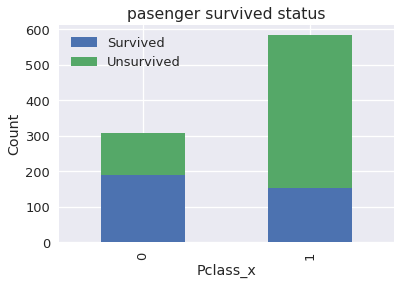

In [34]:
pclass_data = pclass_data.apply(pclass_x, axis=1)

Survived_0 = pclass_data.Pclass_x[pclass_data.Survived==0].value_counts()
Survived_1 = pclass_data.Pclass_x[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Pclass_x") 
plt.ylabel(u"Count")

再看看相关性。

In [35]:
print 'Pclass_x corr Survived:'+str(pclass_data.Pclass_x.corr(pclass_data.Survived))

Pclass_x corr Survived:-0.348304312531


略高于Pclass，可以使用。

##### new

In [36]:
train_data = train_data.apply(pclass_x, axis=1)
test_data = test_data.apply(pclass_x, axis=1)

#### SibSp & Parch

整合一个家庭人数字段看看效果如何。

##### Dig

In [37]:
family_data = train_data[['SibSp','Parch','Survived']].copy()

In [38]:
def familys(row):
    row['Family'] = row['SibSp']+row['Parch']+1
    row['Family'] = row['Family'] if row['Family']<=3 else 4
    return row

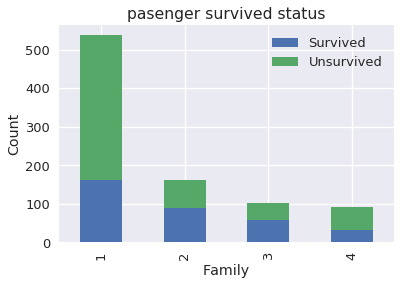

In [39]:
family_data = family_data.apply(familys, axis=1)

Survived_0 = family_data.Family[pclass_data.Survived==0].value_counts()
Survived_1 = family_data.Family[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Family") 
plt.ylabel(u"Count")

可以看到，还是有一些影响的，相对而言，家人多的幸存几率更大，再看看相关系数。

In [40]:
print 'Family corr Survived:'+str(family_data.Family.corr(family_data.Survived))

Family corr Survived:0.124413217827


很不错的相关系数。

##### new

In [41]:
train_data = train_data.apply(familys, axis=1)
test_data = test_data.apply(familys, axis=1)

#### Fare

票价分析同年龄分析，划分上使用分位数。本身Fare具有0.26的相关性，也是很高的。

In [42]:
fare_data = train_data[['Fare','Survived']].copy()

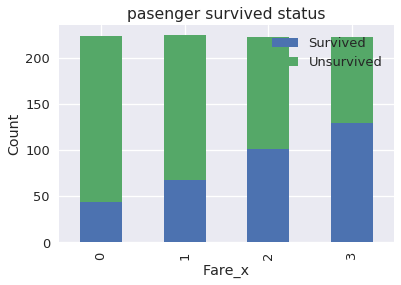

In [43]:
quantile_25 = fare_data.Fare.quantile(0.25)
quantile_50 = fare_data.Fare.quantile(0.50)
quantile_75 = fare_data.Fare.quantile(0.75)
quantile_100 = fare_data.Fare.quantile(0.100)

fare_data['Fare_x'] = fare_data.Fare.apply(lambda f:0 if f<=quantile_25 else (1 if f<=quantile_50 else (2 if f<=quantile_75 else 3)))

Survived_0 = fare_data.Fare_x[fare_data.Survived==0].value_counts()
Survived_1 = fare_data.Fare_x[fare_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Fare_x") 
plt.ylabel(u"Count")

In [44]:
print 'Fare corr with Survived:'+str(fare_data.Fare_x.corr(fare_data.Survived))

Fare corr with Survived:0.299356824981


能够看到该值略高于原Fare，可以使用。

##### new

In [45]:
train_data['Fare_x'] = train_data.Fare.apply(lambda f:0 if f<=quantile_25 else (1 if f<=quantile_50 else (2 if f<=quantile_75 else 3)))
test_data['Fare_x'] = test_data.Fare.apply(lambda f:0 if f<=quantile_25 else (1 if f<=quantile_50 else (2 if f<=quantile_75 else 3)))

#### Cabin

由于Cabin存在大量缺失值，且缺失原因不明，因此不能填充它，但是我们可以考虑根据是否缺失这一特点来可视化一下。

In [46]:
cabin_data = train_data[['Cabin','Survived']].copy()

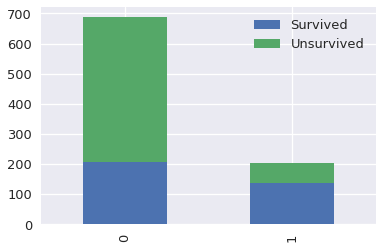

In [47]:
cabin_data['Has_cabin'] = cabin_data.Cabin.apply(lambda c:0 if pd.isnull(c) else 1)

Survived_0 = cabin_data.Has_cabin[cabin_data.Survived==0].value_counts()
Survived_1 = cabin_data.Has_cabin[cabin_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)

可以看到，具有Cabin值的乘客中，大部分都幸存了，这个不确定原因，但是不妨碍我们使用这一特征。

##### new

In [48]:
train_data['Has_cabin'] = train_data.Cabin.apply(lambda c:0 if pd.isnull(c) else 1)
test_data['Has_cabin'] = test_data.Cabin.apply(lambda c:0 if pd.isnull(c) else 1)

#### Embarked

这一属性本身具有0.11的相关性，实际考虑可能登船顺序跟船舱位置有关。

##### Full

In [49]:
train_data.Embarked.fillna(0, inplace=True)
test_data.Embarked.fillna(0, inplace=True)

##### Dig

In [50]:
embarked_data = train_data[['Embarked','Pclass','Survived']].copy()

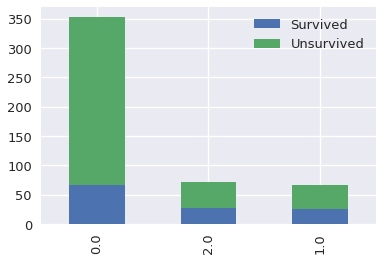

In [51]:
Survived_0 = embarked_data.Embarked[embarked_data.Pclass==3][embarked_data.Survived==0].value_counts()
Survived_1 = embarked_data.Embarked[embarked_data.Pclass==3][embarked_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)

可以看到，数据非常不平衡，因此暂不考虑此字段。

### Useless Feature Drop

当前字段有：

In [52]:
train_data.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Family_name', u'Personal_name', u'Title', u'Age_8', u'Is_child',
       u'Is_female_pclass12', u'Is_male_pclass23', u'Pclass_x', u'Family',
       u'Fare_x', u'Has_cabin'],
      dtype='object')

#### 丢弃前暂存后续有用的字段

In [53]:
target_data = train_data.Survived.copy()
passengerId_data = test_data.PassengerId.copy()

#### 分析可丢弃的字段

1. PassengerId:只在上传kaggle时有用。
2. Survived:目标字段需要丢弃。
3. Name、Family_name、Personal_name:名字相关。
4. Age:使用Age_8、Is_child代替。
5. Fare:使用Fare_x代替。
6. Cabin:使用Has_cabin代替。
7. SibSp、Parch:使用Family代替。
8. Ticket:不知道咋用。

In [54]:
drop_list = ['PassengerId', 'Name', 'Family_name', 'Personal_name', 'Age', 'Fare', 'Cabin', 'SibSp', 'Parch', 'Ticket']

train_data.drop(drop_list, axis=1, inplace=True)
test_data.drop(drop_list, axis=1, inplace=True)

#### 最终热图

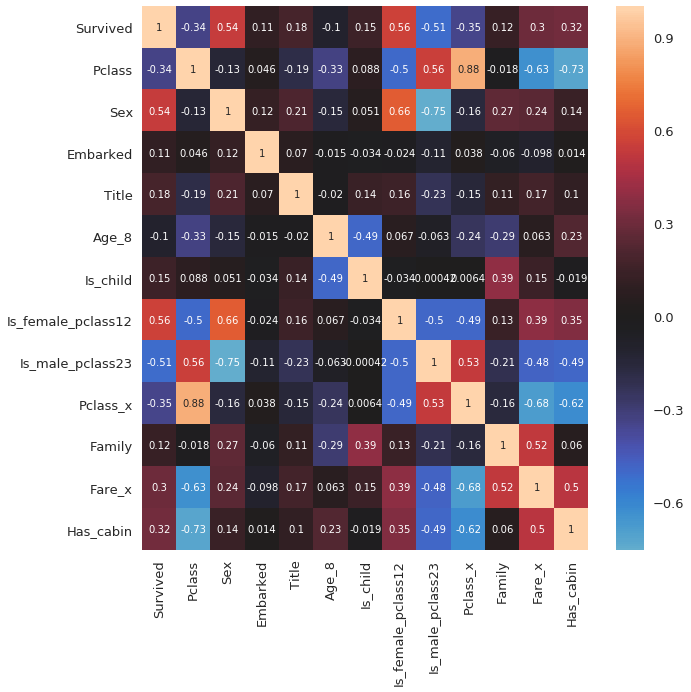

In [55]:
plt.figure(figsize=(10,10))
train_corr = train_data.corr()
sns.heatmap(train_corr, center=0, annot=True)

可以看到，Pclass和Pclass_x有0.88的相关性，说明这两个字段保持一次即可，而他们各自与Survived的相关性上Pclass_x更高一些，因此保留Pclass_x，也就是存在特征之间有重叠的信息，这里我们用PCA降维试一下。

#### 丢弃Survived

In [56]:
train_data.drop(['Survived'], axis=1, inplace=True)

## Data Process

### PCA

In [59]:
pca = PCA(n_components=5).fit(train_data)
print 'explained_variance_ratio:'+str(pca.explained_variance_ratio_)
print 'sum pca.explained_variance_ratio_:'+str(sum(pca.explained_variance_ratio_))

explained_variance_ratio:[ 0.47546066  0.22798916  0.15387244  0.05432671  0.03209418]
sum pca.explained_variance_ratio_:0.943743158063


In [60]:
train_data = pd.DataFrame(pca.transform(train_data))
test_data = pd.DataFrame(pca.transform(test_data))

### Data Split

In [61]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, target_data, test_size=0.2, random_state=6)

## Model Build

### Define Create Method

In [102]:
def xgbc_build(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, gamma=0, 
               min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
               base_score=0.383838383838, random_state=0):
    return XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, 
                         n_estimators=n_estimators, silent=silent, 
                         gamma=gamma,min_child_weight=min_child_weight, 
                         max_delta_step=max_delta_step, random_state=random_state,
                         subsample=subsample, colsample_bytree=colsample_bytree, 
                         base_score=base_score)

### Define Score Method

In [103]:
def score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

### Base Model Valid

In [104]:
xgbc = xgbc_build()
xgbc.fit(x_train, y_train)
y_hat = xgbc.predict(x_valid)
print 'Base Model in Valid:'+str(score(y_valid, y_hat))

Base Model in Valid:0.854748603352


0.860335195531，很不错的准确率了，下面看看参数优化后对准确率的影响吧。

## Parameters Opt

### max_depth & min_child_weight

In [65]:
params = {'max_depth':range(1,10), 'min_child_weight':[0.5,0.6,0.7,0.8,0.9,1]}

xgbc_opt = xgbc_build()

gs = GridSearchCV(xgbc_opt, params)
gs.fit(x_train, y_train)

print gs.best_score_
print gs.best_params_

y_hat_opt = gs.predict(x_valid)
print 'Base Model in Valid:'+str(score(y_valid, y_hat_opt))

0.817415730337
{'max_depth': 3, 'min_child_weight': 0.5}
Base Model in Valid:0.849162011173


### gamma

In [66]:
params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

xgbc_opt = xgbc_build(max_depth=7, min_child_weight=0.8)

gs = GridSearchCV(xgbc_opt, params)
gs.fit(x_train, y_train)

print gs.best_score_
print gs.best_params_

y_hat_opt = gs.predict(x_valid)
print 'Base Model in Valid:'+str(score(y_valid, y_hat_opt))

0.797752808989
{'gamma': 0.3}
Base Model in Valid:0.832402234637


过拟合了，因此gamma还是使用0。

### subsample & colsample_bytree

In [67]:
params = {'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]}

xgbc_opt = xgbc_build(max_depth=7, min_child_weight=0.8)

gs = GridSearchCV(xgbc_opt, params)
gs.fit(x_train, y_train)

print gs.best_score_
print gs.best_params_

y_hat_opt = gs.predict(x_valid)
print 'Base Model in Valid:'+str(score(y_valid, y_hat_opt))

0.810393258427
{'subsample': 0.9, 'colsample_bytree': 0.6}
Base Model in Valid:0.821229050279


依然有过拟合的问题。

### learning_rate & n_estimators

In [68]:
params = {'learning_rate': [0.08,0.09,0.1,0.11,0.12], 'n_estimators': range(50,160,10)}

xgbc_opt = xgbc_build(max_depth=5, min_child_weight=0.8)

gs = GridSearchCV(xgbc_opt, params)
gs.fit(x_train, y_train)

print gs.best_score_
print gs.best_params_

y_hat_opt = gs.predict(x_valid)
print 'Base Model in Valid:'+str(score(y_valid, y_hat_opt))

0.811797752809
{'n_estimators': 80, 'learning_rate': 0.08}
Base Model in Valid:0.837988826816


### Final Model

In [69]:
xgbc_final = xgbc_build(max_depth=5, min_child_weight=0.8, n_estimators=130)
xgbc_final.fit(x_train, y_train)
y_hat_final = xgbc_final.predict(x_valid)
print 'Param Opt Model in Valid:'+str(score(y_valid, y_hat_final))

Param Opt Model in Valid:0.821229050279


## Else Optimization Method

先来看看错误case的情况。

In [70]:
bad_case_index = [True if y==1 else False for y in y_valid+y_hat_final]
valid_data = x_valid.copy()
valid_data['Survived'] = y_valid
valid_data['Pred_survived'] = y_hat_opt
valid_data[bad_case_index][:5]

,0,1,2,3,4,Survived,Pred_survived
17,-1.251401,0.723882,0.692992,-0.209069,-0.566460,1,0
169,-1.086604,-0.231844,-0.467992,-0.078744,-0.886281,0,1
510,-1.405714,-0.563567,1.721321,-0.172742,1.239934,1,0
79,0.748680,-0.456512,1.001667,-0.216469,0.063908,1,0
621,-0.748902,2.136564,-1.946663,-0.244777,-0.429718,1,0


可以看到，大部分划分错误的数据都是非儿童、不是pclass为1,2的女性等结果为幸存，但是预测为没有幸存，也就是说似乎还有一个隐藏的属性会导致乘客幸存但是我们的数据中没有，因此漏掉了很多数据，嗯嗯嗯，到底是什么呢。

### 多模型融合

使用不同的划分数据集训练多个模型，提高模型的泛化能力。

In [105]:
xgbcs = []
for i in range(len(train_data.columns)):
    tmp = train_data#.drop([train_data.columns[i]], axis=1)
    x, x_, y, y_ = train_test_split(tmp, target_data, test_size=0.2, random_state=6)
    xgb = xgbc_build(random_state=i)
    xgb.fit(x, y)#, early_stopping_rounds=30, eval_set=[(x_valid,y_valid)], verbose=True)
    y_hat = xgb.predict(x_)
    print 'Drop '+str(train_data.columns[i])+', and xgb model '+str(i)+' score:'+str(score(y_, y_hat))
    xgbcs.append(xgb)

Drop 0, and xgb model 0 score:0.854748603352
Drop 1, and xgb model 1 score:0.854748603352
Drop 2, and xgb model 2 score:0.854748603352
Drop 3, and xgb model 3 score:0.854748603352
Drop 4, and xgb model 4 score:0.854748603352


In [106]:
def pred_x(x):
    ys = [0]*len(x)
    for i in range(len(xgbcs)):
        xgb = xgbcs[i]
        tmp = x#.drop([x.columns[i]], axis=1)
        y_hat = xgb.predict(tmp)
        ys = [y_hat[i]+ys[i] for i in range(len(x))]
    return [1 if y>len(xgbcs)/2. else 0 for y in ys]

In [107]:
y_hat_multi = pred_x(x_valid)
print score(y_hat_multi, y_valid)

0.854748603352


## 记录

1. 第一版：模型在valid上的得分最终为0.843575418994。
2. 第二版：对base_score修正为0.383838，在valid上最终得分为0.849162011173。
3. 第三版：增加Is_youngman字段，在valid上最终得分为0.793296089385，说明这一特征的加入起到的负面影响更大，先去掉吧。
4. 第四版：增加了多模型融合，对测试集、验证集有提升，但是提交kaggle得分没变。
5. 第五版：增加PCA，目前应该是存在数据维度较高问题的。

## Submit

### 第一次提交

In [82]:
y_test_hat = xgbc.predict(test_data)
y_test_hat_final = xgbc_final.predict(test_data)
y_test_hat_multi = pred_x(test_data)

In [83]:
pd.DataFrame({'PassengerId':list(passengerId_data), 'Survived':y_test_hat}).to_csv('submission_base.csv', index=False)
pd.DataFrame({'PassengerId':list(passengerId_data), 'Survived':y_test_hat_final}).to_csv('submission_opt.csv', index=False)
pd.DataFrame({'PassengerId':list(passengerId_data), 'Survived':y_test_hat_multi}).to_csv('submission_multi.csv', index=False)

#### 得分

排名7288 in 9,879 teams，得分0.76555。